# Lab00: The Full stack of the text recognizer application

course를 통해 neural network를 활용한 OCR application을 제작한다.     
제작 과정을 통해    
- ML-powered application을 개발하는데 있어서 통상적인 원칙들을 학습한다.
- 모든 핵심사항을 포함하는 예제를 익힌다.
- 독립적인 ML-engineer가 되기 위한 최고의 도구와 라이브러리를 익힌다.

In [6]:
from IPython.display import IFrame

app_url = "https://fsdl-text-recognizer.ngrok.io/"

IFrame(app_url, width=1024, height=896)

# Frontend and Backend

위에서 실행한 코드는 "frontend"에 해당하는 부분이다.    
프론트앤드는 보통 "Javascript"로 만들어진다.      
하지만 대부분의 ML은 python으로 수행되기 때문에 이 course에서는 [**Gradio**](https://gradio.app/).를 사용한다.

> <small>다른 툴로는
[Streamlit](https://streamlit.io/) 가 있으며 최근 
[PyScript](https://pyscript.net/)로도 만들어지고 있다.</small>

위 어플리케이션에서 "flag"가 있는 것을 확인할 수 있다.    
이는 사용자의 feedback을 얻는 기능으로 [**Gantry**](https://gantry.io/)를 이용하여 수집된다.      
Gantry를 사용하여 모델의 성능을 모니터링할 수 있고, 경고 발생, 데이터 분석을 수행할 수 있다.

이미지를 읽고 텍스트틀 반호나하는 모델은 프론트앤드와 다른 곳에서 수행된다.     
모델은 "backend"에 해당한다.      
프론트엔드와 백엔드는 JSON API를 통해 분리되어 있다.       
모델은 아마존 웹 서비스인 [**AWS Lambda**](https://aws.amazon.com/lambda/)를 이용하여 [serverlessly](https://serverless-stack.com/chapters/what-is-serverless.html)하게 배포된다.     
AWS lambda는 모델을 담고있는 [**Docker**](https://docker-curriculum.com/) 컨테이너를 실행시킨다.

> <small> Docker는 virtualization/containerization(가상화 / 컨테이너화)를 수행하기 위해 사용하는 도구이다. 컨테이너화 된 어플리케이션의 구조가 복잡해지면서
[container orchestration](https://www.vmware.com/topics/glossary/content/container-management.html)의 역할이 중요해졌다. Docker container의 orchestrating을 위한 주요 도구로
[kubernetes](https://kubernetes.io/)(aka k8s) 가 사용된다.     
k8s를 공급자 관리 시스템을 사용하기 위한 cloud 비전문가는 
[AWS EKS](https://aws.amazon.com/eks/)
or [Google Kubernetes Engine](https://cloud.google.com/kubernetes-engine)를 사용한다.</small>


컨테이너 이미지는 [Elastic Container Registry](https://aws.amazon.com/ecr/)안에 포함된다.      
ECR은 일종의 Docker를 위한 github와 같은 역할을 수행한다.     
severless를 사용하는 것은 모델을 scale up 하는데 필요한 노력을 감소시켜주며     
컨테이너화를 사용하는 것은 개발단계와 배포단계 사이에서 발생하는 에러와 같은 문제들을 줄여준다.     

> <small>이러한 기능은 [Google Cloud Platform](https://cloud.google.com/)
나 [Microsoft Azure](https://azure.microsoft.com/en-us/)와 같은 도구를 이용해서도 수행될 수 있다. 위의 서비스를 이용할 경우 각각 [Google Cloud Functions](https://cloud.google.com/serverless)
과 [Azure Functions](https://azure.microsoft.com/en-us/solutions/serverless),
을 이용한다.
 </small>


백엔드와 프론트엔드는 독립적으로 분리되어 있기 때문에 다양한 방식으로 모델을 작동시킬 수 있다.     
아래 코드를 이용하여 백엔드에 있는 모델에 직접 쿼리를 전달한다.

In [7]:
import json  # JavaScript Object Notation is the lingua franca of the web

from IPython.display import Image
import requests  # requests is the preferred library for web requests in Python

lambda_url = "https://3akxma777p53w57mmdika3sflu0fvazm.lambda-url.us-west-1.on.aws/"
image_url = "https://fsdl-public-assets.s3-us-west-2.amazonaws.com/paragraphs/a01-077.png"

headers = {"Content-type": "application/json"}  # headers ensure our request is handled correctly
payload = json.dumps({"image_url": image_url})  # the request content is a string representation of JSON data

if "pred" not in locals():  # a poor man's cache: if we've defined the variable pred, skip the request
  response = requests.post(  # we POST the image to the URL, expecting a prediction as a response
      lambda_url, data=payload, headers=headers)
  pred = response.json()["pred"]  # the response is also json

print(pred)

Image(url=image_url, width=512)

And, since this is election year in West
Germany, Dr. Adenauer is in a tough
spot. Joyce Egginton cables: President
Kennedy at his Washington Press con-
ference admitted he did not know
whether America was lagging behind
Russia in missile power. He said he
was waiting for his senior military
aides to come up with the answer on
February 20.


# Appication diagram

Text recognizer를 만드는데 수행하는 전체적인 diagram은 아래와 같다.

In [8]:
diagram_url = "https://miro.com/app/live-embed/uXjVOrOHcOg=/?moveToViewport=-1210,-1439,2575,1999"

IFrame(diagram_url, width=1024, height=512)

# Model Training

coures의 시작 단계인 모델 개발로 돌아와서, 모델을 만든 후 위의 배포 단계로 돌아간다.     
neural network(이미지 처리를 위한 Renet encoder, 텍스트 output 형성을 위한 transformer decoder)

Neural network는 큰 사이즈의 matrix 연산에 의해 수행된다. 이러한 연산은 병렬 계산의 유용성 덕분에 GPU에서 수행하는 것이 CPU에서 실행하는 것보다 빠르다.      
여러 GPU를 구매하는 것은 큰 비용문제가 발생하므로, 이 강의에서는 cloud 기능을 사용한다.[**Lambda Labs GPU Cloud**](https://lambdalabs.com/service/gpu-cloud).    
> <small> WAS나 GCP와 같은 서비스도 존재하지만 labmda lab이 가격 면에서 가장 합리적이다. (2022/08) 기준
 </small>     

debugging과 quick experiment와 같은 연산량이 비교적 작은 작업을 수행할 때에는 Colab을 이용한다.


아래는 기본적인 GPU 정보를 보여주는 명령어이다.

In [9]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [10]:
import this  # The Zen of Python

구현으로는 python과 pytorch를 이용한다.

In [11]:
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"  # run on GPU if available

# create an array/tensor and track its gradients during calculations
a = torch.tensor([1.], requires_grad=True) \
  .to(device)  # store the array data on GPU (if available)
b = torch.tensor([2.]).to(device)

# calculate new values, building up a "compute graph"
c = a * b + a

# compute gradient of c with respect to a by "tracing the graph backwards"
g, = torch.autograd.grad(outputs=c, inputs=a)

g

tensor([3.])

Pytorch는 deep neural network를 구현하기 위한 여러가지 기능들을 제공하지만,     
모델 훈련, metric caculation, model-checkpointing과 같은 high-level frame-work를 포함하지 않는다.     
따라서 high-level training을 위해 [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/)을 이용한다.     
> <small> Pytorch lightning은 pytorch를 사용한다면 일반적으로 사용하는 framework지만, 자연어 처리 분야에서는 [Hugging Face](https://hugginface.co/)를 이용한다.     
[Keras](https://keras.io/)는 Tensorflow에서 채택한 프레임워크이며,      
JAX는 [Flax](https://github.com/google/flax)를 사용한다. in others, there is not as of July 2022 a high-level
training framework in JAX.
 </small>

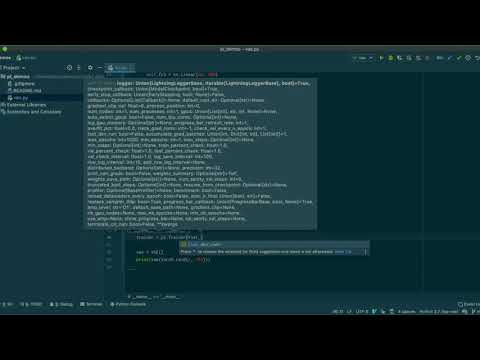

In [12]:
from IPython.display import YouTubeVideo

lit_video_id = "QHww1JH7IDU"
YouTubeVideo(lit_video_id, modestbranding=True, rel=False, width=512)

# Experiment and Artifact tracking

ML모델의 결과는 사람에게는 명확해도 프로그래밍 방식으로 판단하기에는 모호한 부분이 있을 수 있기 때문에 ML models은 디버그에 어려움이 있다.     
또한 hyperparameter와 같이 바꿔줄 수 있는 요소들이 많이 존재한다.      
때문에 ML modeling은 프로그래밍 보다 실험에 가까울 때가 있다. 이러한 실험들은 케이스 수가 많아질수록 tracking의 필요성이 증가된다.(binary file, artifact, model weights)     
우리는 artifact tracking을 위해 [Weights & Biases](http://docs.wandb.ai)를 이용한다.

> <small>[MLFlow](https://github.com/mlflow/mlflow)는 W&B보다 비슷한 기능을 지원하는 open source 라이브러리이다. 그러나 mlflow는 서버가 self-hosting 되어야 하기 때문에 이미 할일이 많은 Ml developer에게 번거로운 업무가 추가된다.     
[Tensorboard](https://www.tensorflow.org/tensorboard)는 [tensorboard.dev](https://tensorboard.dev/)에서 제공하는 서비스이지만 artifact tracking 기능을 제공하지 않는다.     
[Git LFS](https://git-lfs.github.com/)는 artifact tracking 기능을 제공하지만 가격이 비싸고 expriemnt tracking기능을 제공하지 않는다.      
[Hugging Face](https://huggingface.co/)는 git server의 대체제러써 tensorboard의 결과를 확인할 수 있으며, 용량이 큰 파일에 대해 Git LFS를 이용한다(where large means >10MB). 

</small>      
이러한 배포가능한 모델은 W&B 에 저장되어 모델이 만들어진 체크포인트를 제공하는 expriment, training과 같은 다양한 metadata와 연동된다.      
아래 코드는 Text recognizer 배포 버전의 메타데이터를 불러온다.



In [13]:
artifact_url = "https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/artifacts/prod-ready/paragraph-text-recognizer/v8"

IFrame(artifact_url, width=1024, height=768)

우리는 위의 파일을 다운받아서 약간의 파이썬 코드를 포함하는 Docker container에 패키징하고, 컨테이너 레지스트리(docker hub or AWS ECR)에 저장한 다음 어플리케이션의 백엔드에 제공하여 사용할 수 있다.

# Application Diagram, Redux

Now that we have made it through the
🥞 full stack 🥞 of the Text Recognizer application,
let's take a look at the application diagram again.

In [15]:
IFrame(diagram_url, width=1024, height=512)

labs을 통해 우리는 모든 조각들을 맞춰나갈 것이다. 그 과정에서 각 조각들이 해결하는 문제들에 대해 배우고, trade-off를 고려하고, 최선의 선택을 하는 방법을 배운다.